# Local notebook - First approach

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from spacy.util import compounding
from spacy.util import minibatch

import os
import random

from tqdm import tqdm

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pmbrull/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pmbrull/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## EDA

In [153]:
raw_df = pd.read_csv('../data/train.csv')
raw_df.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [154]:
raw_df.shape

(27486, 4)

In [155]:
# remove missing values
raw_df = raw_df.dropna()
raw_df.shape

(27485, 4)

### Sentiment Distribution

In [156]:
print(raw_df['sentiment'].value_counts().values)
print(raw_df['sentiment'].unique())

[11117  8582  7786]
['neutral' 'positive' 'negative']


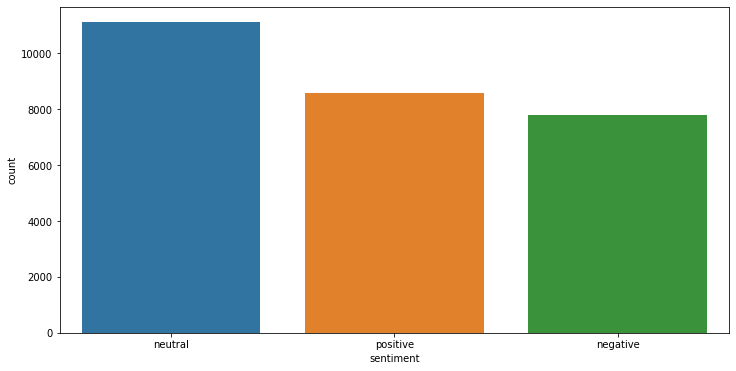

In [157]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=raw_df)

In [158]:
# Let's check one example of each:
print("Positive:",raw_df[raw_df['sentiment']=='positive']['text'].values[0])
print("Negative:",raw_df[raw_df['sentiment']=='negative']['text'].values[0])
print("Neutral:",raw_df[raw_df['sentiment']=='neutral']['text'].values[0])

Positive:  Oh! Good idea about putting them on ice cream
Negative:  i dont think you can vote anymore! i tried
Neutral: Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning


In [159]:
# We could try to guess which words would be selected in the positive and negative case:
# For positive we could say "Good idea"
# For negative: "i dont think"
print("Positive:",raw_df[raw_df['sentiment']=='positive']['selected_text'].values[0])
print("Negative:",raw_df[raw_df['sentiment']=='negative']['selected_text'].values[0])
print("Neutral:",raw_df[raw_df['sentiment']=='neutral']['selected_text'].values[0])

Positive: Good
Negative: i dont think you can vote anymore!
Neutral: my boss was not happy w/ them. Lots of fun.


In [160]:
# all in all, somehow accurate

## Preprocess

In [161]:
def text_to_words(text, return_list=True):
    lower = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = lower.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    # words = [PorterStemmer().stem(w) for w in words] # stem
    words = [lemmatizer.lemmatize(w) for w in words]
    words = ' '.join(words)
    
    return words

def get_cache(cache_dir, cache_file):
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pd.read_pickle(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
        
    return cache_data

def clean_data(df):
    clean_text = df['text'].apply(text_to_words)
    clean_extracted_text = df['selected_text'].apply(text_to_words)

    clean_df = pd.DataFrame({
        'text': clean_text,
        'selected_text': clean_extracted_text,
        'sentiment': df['sentiment']
    })
    
    return clean_df

def preprocess_df(df, cache_dir='../cache', cache_file="clean_data.pkl"):
    
    os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists
    
    cache_data = get_cache(cache_dir, cache_file)
    
    if cache_data is None:
        cache_data = clean_data(df)
        cache_data.to_pickle(os.path.join(cache_dir, cache_file))

    return cache_data

In [162]:
# clean_df = preprocess_df(raw_df)
clean_df = preprocess_df(raw_df)

In [163]:
clean_df.head()

,text,selected_text,sentiment
0,spent entire morning meeting w vendor bos happ...,bos happy w lot fun,neutral
1,oh good idea putting ice cream,good,positive
2,say good say bad afternoon http plurk com p wxpdj,say good say bad afternoon,neutral
3,dont think vote anymore tried,dont think vote anymore,negative
4,haha better drunken tweeting mean,better,positive


## Model


In [164]:
def save_model(output_dir, nlp, new_model_name):
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [165]:
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [166]:
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    else:
        model_out_path = 'models/model_neu'
    return model_out_path

In [167]:
## creating data in spacy data input format

def get_training_data(df, sentiment):
    train_data = []
    sentiment_df = df.loc[df['sentiment'] == sentiment]
    for index, row in sentiment_df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

### TRAIN

In [168]:
## Train positive

sentiment = 'positive'

train_data = get_training_data(raw_df, sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:27<00:55, 27.58s/it]

Losses {'ner': 33832.71321033541}


 67%|██████▋   | 2/3 [00:54<00:27, 27.45s/it]

Losses {'ner': 31469.29956783507}


100%|██████████| 3/3 [01:22<00:00, 27.35s/it]

Losses {'ner': 29919.369314272495}
Saved model to ../working/models/model_pos


In [171]:
sentiment = 'negative'

train_data = get_training_data(raw_df, sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=2, model=None)

  0%|          | 0/2 [00:00<?, ?it/s]

Created blank 'en' model


 50%|█████     | 1/2 [00:26<00:26, 26.40s/it]

Losses {'ner': 32653.55848553151}


100%|██████████| 2/2 [00:55<00:00, 27.59s/it]

Losses {'ner': 28817.389152683038}
Saved model to ../working/models/model_neg


In [172]:
sentiment = 'neutral'

train_data = get_training_data(raw_df, sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=2, model=None)

  0%|          | 0/2 [00:00<?, ?it/s]

Created blank 'en' model


 50%|█████     | 1/2 [00:35<00:35, 35.48s/it]

Losses {'ner': 7911.316968408187}


100%|██████████| 2/2 [01:11<00:00, 35.91s/it]

Losses {'ner': 5689.52009303563}
Saved model to ../working/models/model_neu


### PREDICT

In [173]:
model_pos = spacy.load('../working/models/model_pos')
model_neg = spacy.load('../working/models/model_neg')
model_neu = spacy.load('../working/models/model_neu')

In [174]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [175]:
selected_texts = []
for index, row in test_df.iterrows():
    text = row.text
    output_str = ""
    if row.sentiment == 'neutral' or len(text.split()) < 4:
        selected_texts.append(text)
    elif row.sentiment == 'positive':
        selected_texts.append(predict_entities(text, model_pos))
    else:
        selected_texts.append(predict_entities(text, model_neg))
        
test_df['selected_text_pred'] = selected_texts

In [176]:
test_df.loc[test_df['sentiment'] == 'positive'].head(10)

,textID,text,selected_text,sentiment,sentiment_terms,selected_text_pred
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,,Good
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,,haha better drunken tweeting you mean?
6,2ab82634d5,had an awsome salad! I recommend getting the S...,had an awsome salad!,positive,,had an awsome salad! I recommend getting the S...
7,a5a1c996c0,fine! Going to do my big walk today 20 or so ...,fine!,positive,,fine!
8,a182b2638e,Thank a yoou how are you? #TwitterTakeover,Thank,positive,,Thank
13,bc0f2cb758,Have just bought a TV tuner for my laptop. He...,Have just bought a TV tuner for my laptop. He...,positive,,deserve
23,22744e80f7,12:46AM. HAppy birthday little sister of mine....,HAppy birthday little sister of mine.,positive,,HAppy
24,e487233140,aaawww no worries fresh start to work on gro...,aaawww no worries,positive,,aaawww no worries fresh start to work on gro...
26,01cfa3807e,is sooo tired and too busy to tweet im glad t...,glad,positive,,glad
29,a6c77ff610,Just watched &quot;Marley &amp; Me.&quot; Cute...,mp; Me,positive,,Cute


In [177]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [182]:
test_df['score'] = test_df[['selected_text','selected_text_pred']].apply(lambda x: jaccard(*x), axis=1)
test_df.head()

,textID,text,selected_text,sentiment,sentiment_terms,selected_text_pred,score
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,,Spent the entire morning in a meeting w/ a ven...,0.416667
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,,Good,1.000000
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,,says good (or should i say bad?) afternoon! h...,0.888889
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,,i dont think you can vote anymore! i tried,0.875000
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,,haha better drunken tweeting you mean?,0.166667


In [186]:
# Final Score
test_df['score'].sum() / test_df.shape[0]

0.6457666667680935

In [189]:
test_df.loc[test_df['sentiment'] == 'positive'].head(20)

,textID,text,selected_text,sentiment,sentiment_terms,selected_text_pred,score
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,,Good,1.000000
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,,haha better drunken tweeting you mean?,0.166667
6,2ab82634d5,had an awsome salad! I recommend getting the S...,had an awsome salad!,positive,,had an awsome salad! I recommend getting the S...,0.363636
7,a5a1c996c0,fine! Going to do my big walk today 20 or so ...,fine!,positive,,fine!,1.000000
8,a182b2638e,Thank a yoou how are you? #TwitterTakeover,Thank,positive,,Thank,1.000000
13,bc0f2cb758,Have just bought a TV tuner for my laptop. He...,Have just bought a TV tuner for my laptop. He...,positive,,deserve,0.071429
23,22744e80f7,12:46AM. HAppy birthday little sister of mine....,HAppy birthday little sister of mine.,positive,,HAppy,0.166667
24,e487233140,aaawww no worries fresh start to work on gro...,aaawww no worries,positive,,aaawww no worries fresh start to work on gro...,0.250000
26,01cfa3807e,is sooo tired and too busy to tweet im glad t...,glad,positive,,glad,1.000000
29,a6c77ff610,Just watched &quot;Marley &amp; Me.&quot; Cute...,mp; Me,positive,,Cute,0.000000
